In [3]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [4]:
# 超参数设置
config = {
    "model_name": "resnet",  # 可选 "resnet" 或 "vgg"
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "test_size": 0.2,
    "sample_ratio": 1.0
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Aerial_Landscapes/"


In [5]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    input_size = 224
    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vgg":
        model = models.vgg16(pretrained=use_pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError("不支持的模型名称，请选择 'resnet' 或 'vgg'")
    return model, input_size


In [6]:
def get_transforms(input_size=224):
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform


In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label


In [8]:
def load_and_split_dataset(root_dir, test_size=0.2, sample_ratio=1.0):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    for cls_name in classes:
        cls_path = os.path.join(root_dir, cls_name)
        img_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(img_files)
        n_samples = int(len(img_files) * sample_ratio)
        split = int(n_samples * (1 - test_size))
        imgs = img_files[:n_samples]
        train_imgs = imgs[:split]
        test_imgs = imgs[split:]
        train_images.extend([cv2.imread(p) for p in train_imgs])
        train_labels.extend([class_to_idx[cls_name]] * len(train_imgs))
        test_images.extend([cv2.imread(p) for p in test_imgs])
        test_labels.extend([class_to_idx[cls_name]] * len(test_imgs))

    return (train_images, train_labels), (test_images, test_labels), classes


In [9]:

def train_model(model, device, train_loader, test_loader, criterion, optimizer,
                num_epochs=25, checkpoint_path='checkpoint.pth', patience=5):
    """
    模型训练函数，加入 Early Stopping 和历史记录
    """
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(num_epochs):
        if early_stop:
            print(f"⚠️ 早停触发于第 {epoch+1} 轮")
            break

        # 训练阶段
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_train_loss = train_loss / total_train
        epoch_train_acc = correct_train.double() / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())

        # 验证阶段
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)

        epoch_test_loss = test_loss / total_test
        epoch_test_acc = correct_test.double() / total_test
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc.item())

        print(f"Epoch {epoch+1}: Train Acc={epoch_train_acc:.4f}, Test Acc={epoch_test_acc:.4f}")

        # Early Stopping 判断
        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True

    return model, history


In [10]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.6470, Test Acc=0.7329
Epoch 2: Train Acc=0.7592, Test Acc=0.8263
Epoch 3: Train Acc=0.8070, Test Acc=0.8592
Epoch 4: Train Acc=0.8238, Test Acc=0.8971
Epoch 5: Train Acc=0.8397, Test Acc=0.8938
Epoch 6: Train Acc=0.8409, Test Acc=0.8788
Epoch 7: Train Acc=0.8564, Test Acc=0.8729
Epoch 8: Train Acc=0.8569, Test Acc=0.8683
Epoch 9: Train Acc=0.8641, Test Acc=0.8871
⚠️ 早停触发于第 10 轮
Evaluation Metrics (Precision, Recall, F1-score):

              precision    recall  f1-score   support

 Agriculture     0.7404    0.9625    0.8370       160
     Airport     0.7363    0.9250    0.8199       160
       Beach     0.9018    0.9187    0.9102       160
        City     0.9259    0.7812    0.8475       160
      Desert     0.9685    0.7688    0.8571       160
      Forest     0.9686    0.9625    0.9655       160
   Grassland     0.9853    0.8375    0.9054       160
     Highway     0.9416    0.9062    0.9236       160
        Lake     0.8910    0.8688    0.8797       160
    Mo

<Figure size 1200x1000 with 0 Axes>

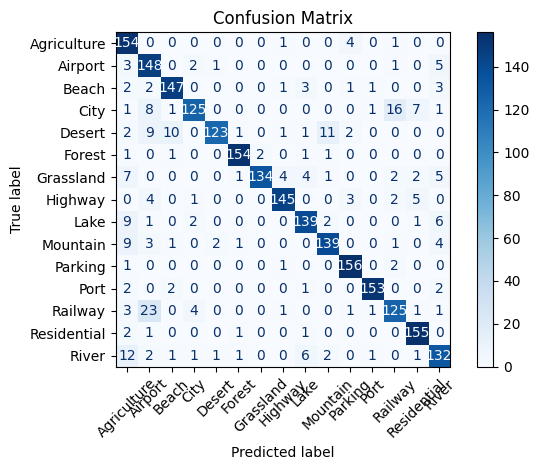

In [11]:
# 加载数据
(train_images, train_labels), (test_images, test_labels), classes = load_and_split_dataset(
    dataset_path,
    test_size=config["test_size"],
    sample_ratio=config["sample_ratio"]
)

# 初始化模型
model, input_size = initialize_model(
    model_name=config["model_name"],
    num_classes=len(classes),
    use_pretrained=True
)
model = model.to(device)

# 数据增强
train_transform, test_transform = get_transforms(input_size)

# 构建Dataset和Loader
train_dataset = CustomDataset(train_images, train_labels, train_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# 损失函数与优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# 训练模型
model, history = train_model(
    model, device, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=config["num_epochs"],
    patience=5
)

# 评估
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

# 输出三种指标：precision、recall、f1-score
report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Evaluation Metrics (Precision, Recall, F1-score):\n")
print(report)

# 混淆矩阵可视化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(12, 10))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


In [12]:
def run_and_evaluate(model_name, classes):
    # 加载数据
    (train_images, train_labels), (test_images, test_labels), _ = load_and_split_dataset(
        dataset_path,
        test_size=config["test_size"],
        sample_ratio=config["sample_ratio"]
    )

    # 初始化模型
    model, input_size = initialize_model(
        model_name=model_name,
        num_classes=len(classes),
        use_pretrained=True
    )
    model = model.to(device)

    # 数据增强
    train_transform, test_transform = get_transforms(input_size)

    # 构建数据集与加载器
    train_dataset = CustomDataset(train_images, train_labels, train_transform)
    test_dataset = CustomDataset(test_images, test_labels, test_transform)
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    # 损失函数与优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    # 训练模型
    model, _ = train_model(
        model, device, train_loader, test_loader,
        criterion, optimizer,
        num_epochs=config["num_epochs"],
        patience=5
    )

    # 评估指标与混淆矩阵
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print(f"===== {model_name.upper()} Evaluation Metrics =====\n")
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(12, 10))
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name.upper()}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


🔍 正在比较 ResNet18 与 VGG16 的分类性能...



/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.6731, Test Acc=0.6804
Epoch 2: Train Acc=0.7688, Test Acc=0.8050
Epoch 3: Train Acc=0.8008, Test Acc=0.8608
Epoch 4: Train Acc=0.8149, Test Acc=0.8771
Epoch 5: Train Acc=0.8378, Test Acc=0.8338
Epoch 6: Train Acc=0.8446, Test Acc=0.8850
Epoch 7: Train Acc=0.8563, Test Acc=0.8946
Epoch 8: Train Acc=0.8584, Test Acc=0.8954
Epoch 9: Train Acc=0.8676, Test Acc=0.8750
Epoch 10: Train Acc=0.8716, Test Acc=0.9092
Epoch 11: Train Acc=0.8767, Test Acc=0.9246
Epoch 12: Train Acc=0.8830, Test Acc=0.9071
Epoch 13: Train Acc=0.8784, Test Acc=0.9208
Epoch 14: Train Acc=0.8901, Test Acc=0.8829
Epoch 15: Train Acc=0.8906, Test Acc=0.9163
===== RESNET Evaluation Metrics =====

              precision    recall  f1-score   support

 Agriculture     0.8947    0.9563    0.9245       160
     Airport     0.8421    0.9000    0.8701       160
       Beach     0.9733    0.9125    0.9419       160
        City     0.9375    0.8438    0.8882       160
      Desert     0.9605    0.9125    0.

<Figure size 1200x1000 with 0 Axes>

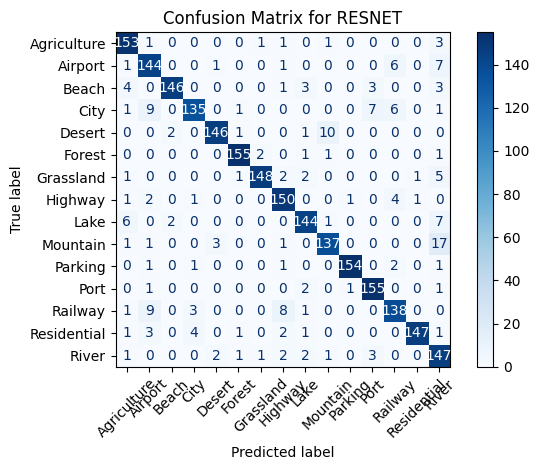

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.1843, Test Acc=0.1592
Epoch 2: Train Acc=0.3057, Test Acc=0.4167
Epoch 3: Train Acc=0.3873, Test Acc=0.3896
Epoch 4: Train Acc=0.4379, Test Acc=0.4204
Epoch 5: Train Acc=0.4613, Test Acc=0.4954
Epoch 6: Train Acc=0.4926, Test Acc=0.4733
Epoch 7: Train Acc=0.5018, Test Acc=0.4638
Epoch 8: Train Acc=0.5085, Test Acc=0.5492
Epoch 9: Train Acc=0.5316, Test Acc=0.5438
Epoch 10: Train Acc=0.5513, Test Acc=0.5842
Epoch 11: Train Acc=0.5502, Test Acc=0.5988
Epoch 12: Train Acc=0.5591, Test Acc=0.6033
Epoch 13: Train Acc=0.5592, Test Acc=0.6092
Epoch 14: Train Acc=0.5860, Test Acc=0.6213
Epoch 15: Train Acc=0.5770, Test Acc=0.6058
===== VGG Evaluation Metrics =====

              precision    recall  f1-score   support

 Agriculture     0.7097    0.4125    0.5217       160
     Airport     0.3450    0.3688    0.3565       160
       Beach     0.5952    0.6250    0.6098       160
        City     0.4345    0.7250    0.5433       160
      Desert     0.8563    0.8938    0.874

<Figure size 1200x1000 with 0 Axes>

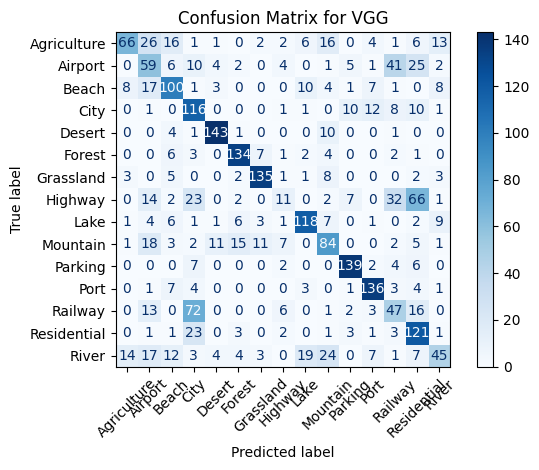

In [13]:
# 同时比较 ResNet 和 VGG
print("🔍 正在比较 ResNet18 与 VGG16 的分类性能...\n")
run_and_evaluate("resnet", classes)
run_and_evaluate("vgg", classes)


In [14]:

import cv2
import numpy as np
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import os
import torch

def overlay_heatmap(img: np.ndarray, cam: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    if img.max() > 1.0:
        img = np.float32(img) / 255
    if img.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlayed = heatmap * alpha + img
    overlayed = overlayed / np.max(overlayed)
    return np.uint8(255 * overlayed)


def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def apply_gradcam(model, device, dataloader, model_name="resnet", num_images=1, save_dir="gradcam_outputs"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    if model_name == "resnet":
        target_layer = model.layer4[-1].conv2
    elif model_name == "vgg":
        target_layer = model.features[-1]
    else:
        raise ValueError("Unsupported model")

    cam_extractor = GradCAM(model, target_layer=target_layer)

    shown = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        for i in range(min(num_images, inputs.shape[0])):
            img_tensor = inputs[i]
            class_idx = torch.argmax(outputs[i]).item()

            cam_tensor = cam_extractor(class_idx=class_idx, scores=outputs[i].unsqueeze(0))[0]
            cam = cam_tensor.cpu().numpy()
            if cam.ndim == 3:
                cam = cam[0]
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

            raw_image = img_tensor.permute(1, 2, 0).cpu().numpy()
            cam = cv2.resize(cam, (raw_image.shape[1], raw_image.shape[0]))
            result = overlay_heatmap(raw_image, cam)
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            # 🟢 Unnormalize image
            unnorm_img_tensor = unnormalize(img_tensor.clone().cpu(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            raw_image = unnorm_img_tensor.permute(1, 2, 0).numpy()
            raw_image = np.clip(raw_image, 0, 1)

            cam = cv2.resize(cam, (raw_image.shape[1], raw_image.shape[0]))
            result = overlay_heatmap(raw_image, cam)
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            # 保存原图
            orig_img = np.uint8(raw_image * 255)
            orig_bgr = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)
            orig_path = os.path.join(save_dir, f"original_{model_name}_img{i}_class{class_idx}.png")
            cv2.imwrite(orig_path, orig_bgr)

            # 保存热图
            heatmap_path = os.path.join(save_dir, f"gradcam_{model_name}_img{i}_class{class_idx}.png")
            cv2.imwrite(heatmap_path, cv2.cvtColor(result_rgb, cv2.COLOR_RGB2BGR))

            # 拼接图像保存
            combined = np.hstack((orig_bgr, cv2.cvtColor(result_rgb, cv2.COLOR_RGB2BGR)))
            compare_path = os.path.join(save_dir, f"compare_{model_name}_img{i}_class{class_idx}.png")
            cv2.imwrite(compare_path, combined)

            # 可视化
            plt.figure(figsize=(5, 5))
            plt.imshow(result_rgb)
            plt.title(f"Grad-CAM ({model_name.upper()}) - Class {class_idx}")
            plt.axis('off')
            plt.show()

            shown += 1
        if shown >= num_images:
            break


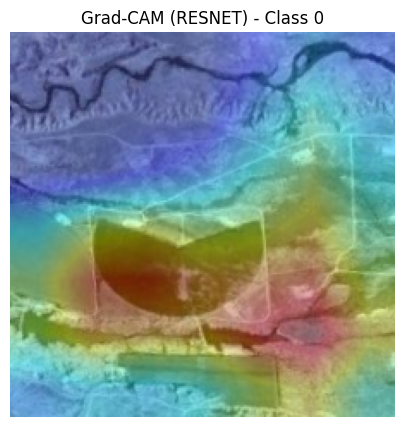

In [15]:
apply_gradcam(model, device, test_loader, model_name="resnet", num_images=1)